## Lab 2: Text Classification

Note: For this lab exercise, it is recommended that you use [Google colab](https://colab.research.google.com/) to avoid issues concerning the deep learning module dependencies on your local system.

For questions contact:

Yongchao Wu

email ID: yongchao.wu@dsv.su.se

## 1. Introduction


In this lab exercise, we will perform classification of text into predefined classes using Machine Learning. In particular, we will be classifying the text from [BBC](http://mlg.ucd.ie/datasets/bbc.html) dataset consisting of 5 different classes.

In [1]:
import pandas as pd
import os
import numpy as np
import gradio as gr

## Suppress warnings

import warnings
warnings.filterwarnings("ignore")

### 2. Import Dataset


In [2]:
# Note: The filepath has been specified considerning that the notebook is run using google colab.

#!wget https://raw.githubusercontent.com/yonwu/nlp_lab2/main/bbc_text.csv



In [3]:
bbc = pd.read_csv('bbc_text.csv', delimiter = ',')
bbc.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
## To do: Randomly Select 100 examples from bbc dataframe, save to a new dataframe bbc_100
bbc_100 = bbc.sample(n=100, random_state=1)
print(bbc_100.shape)
bbc_100

(100, 2)


,category,text
1664,sport,blues slam blackburn over savage birmingham ha...
1347,politics,mps tout lords replacement plan a group of mps...
432,sport,england 17-18 france england suffered an eight...
1435,business,banker loses sexism claim a former executive a...
1374,tech,eu software patent law faces axe the european ...
...,...,...
1972,business,bat spit drug firm goes to market a german fir...
1723,tech,pc photo printers challenge pros home printed ...
2079,sport,holmes starts 2005 with gb events kelly holmes...
1768,sport,curbishley delight for johansson charlton mana...


In [5]:
from sklearn.model_selection import KFold
## To do: created 5-fold with KFold (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
kf = KFold(n_splits=5, shuffle=True)

## Visualizing K-Fold

###Run the following code, if you have done the bbc samling and kf correctly, you will see the distribution of the Train/Test dataset in each fold.

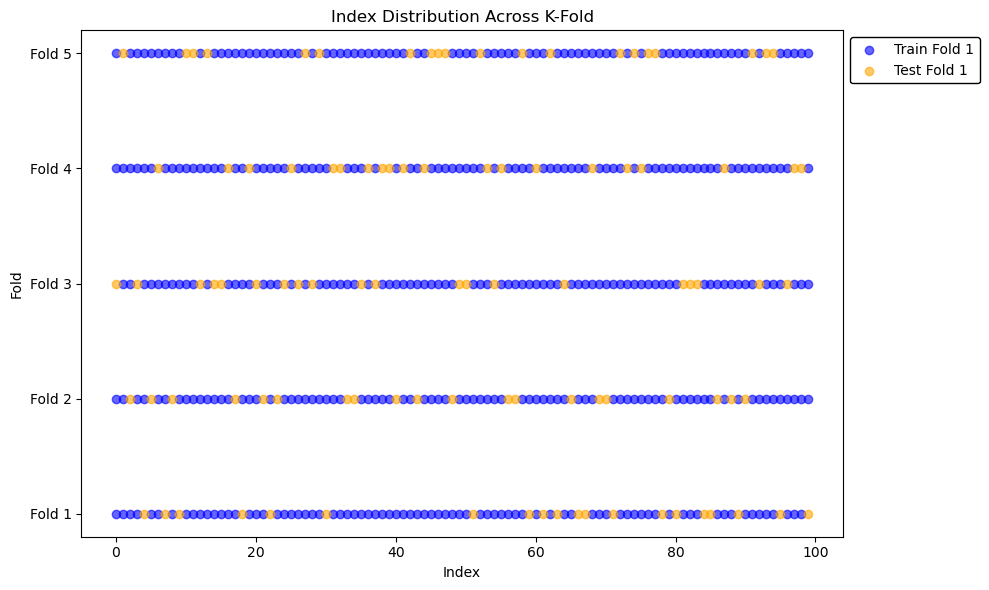

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i, (train_index, test_index) in enumerate(kf.split(bbc_100)):
    # Display train index distribution
    plt.scatter(train_index, [i] * len(train_index), alpha=0.6, label=f'Train Fold {i+1}' if i == 0 else "", color='blue')

    # Display test index distribution
    plt.scatter(test_index, [i] * len(test_index), alpha=0.6, label=f'Test Fold {i+1}' if i == 0 else "", color='orange')


plt.xlabel('Index')
plt.ylabel('Fold')
plt.title('Index Distribution Across K-Fold')
plt.yticks(np.arange(5), [f'Fold {i+1}' for i in range(5)])

# Adjust the legend
legend = plt.legend(frameon=True, loc='upper left', bbox_to_anchor=(1, 1))
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame.set_alpha(1)  # Adjust transparency: 0 is transparent, 1 is opaque

plt.tight_layout()
plt.show()

### Question: What is the benifit of K-fold cross validation? any disadvantages?


# - Advantages


*   Each subset is given a chance to be in the test set
*   Performance is averaged over the k iterations

# - Disadvantages



*   Training on less training examples will result on higher bias (depending on how representive are the remaining training examples in each fold)
*   Not good results if k-fold is not stratified





### 3. Visualization

Your task here is to get an understanding of distribution of different classes in the data by visualization and compare them.

You are expected to generate two plots, one for each training and test dataset.

You can refer to the [Bar plots tutorial](https://pythonguides.com/matplotlib-plot-bar-chart/) to know more.

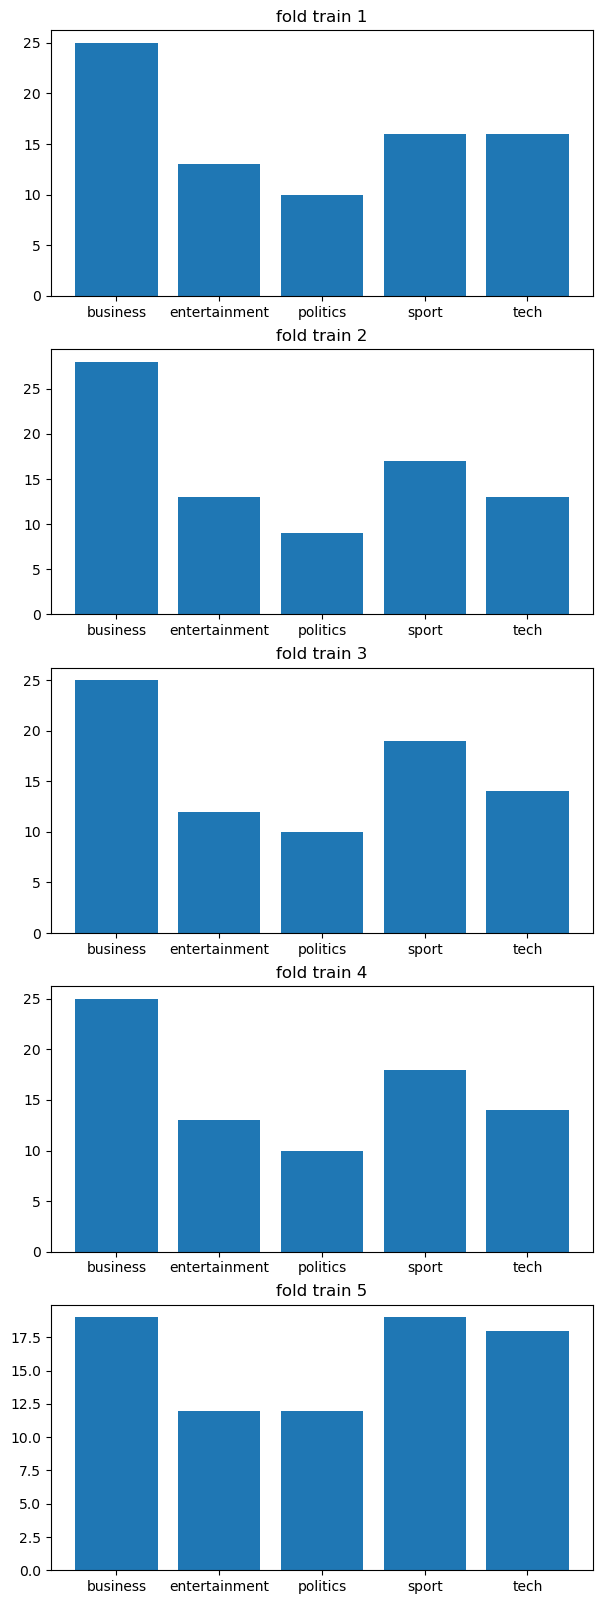

In [7]:
import matplotlib.pyplot as plt

# Solution: add the code below to plot the Distribution of classes in bbc_100 for each fold to separate staple diagrams for each fold.
#bbc_100_cat = bbc_100[['category']].value_counts(sort=False).reset_index().rename(columns={0: "count"})
bbc_100_cat = bbc_100.reset_index(drop=True)
bbc_100_np = bbc_100_cat.to_numpy()
#bbc_100_np[:, -1:].flatten()
#X=bbc_100_np[:, -1:].flatten(), y=bbc_100_np[:, :1].flatten())

folds = [next(kf.split(bbc_100_np)) for i in range(5)]

fig, axs = plt.subplots(5, figsize=(7, 20))

for i, ax in enumerate(axs.flatten()):
  a = bbc_100_np[folds[i][0]][:,:1].flatten()

  df1 = pd.DataFrame(a,columns=['category'])
  df1 = df1.value_counts(sort=False).reset_index().rename(columns={0: "count"})

  ax.bar(df1['category'], df1['count'])
  ax.set_title(f'fold train {i+1}')

plt.show()

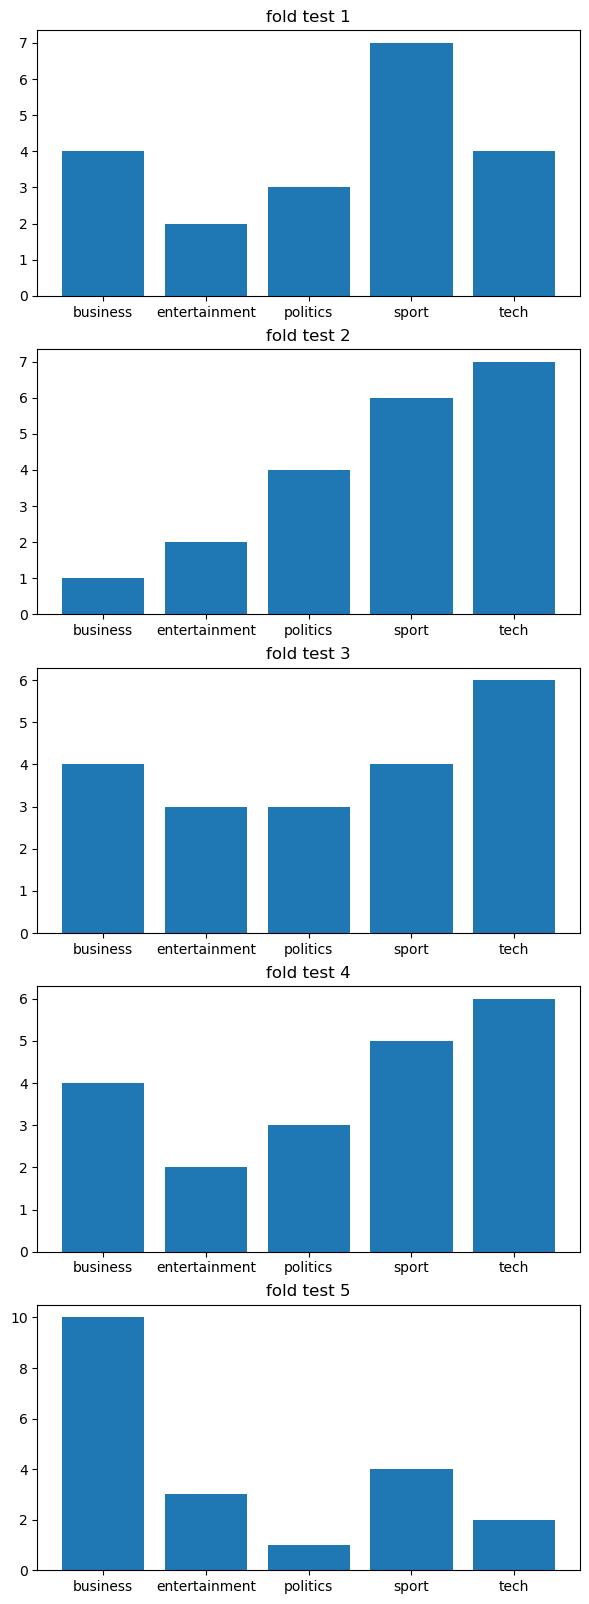

In [8]:
fig, axs = plt.subplots(5, figsize=(7, 20))

for i, ax in enumerate(axs.flatten()):
  a = bbc_100_np[folds[i][1]][:,:1].flatten()

  df1 = pd.DataFrame(a,columns=['category'])
  df1 = df1.value_counts(sort=False).reset_index().rename(columns={0: "count"})

  ax.bar(df1['category'], df1['count'])
  ax.set_title(f'fold test {i+1}')

plt.show()

### 5. Classification using Naive Bayes

For training and validation, we will use a [Multinomial Naive Bayes classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). Here, you are expected to:

1. Vectorize the text from the training set.
2. Train the classifier
3. Evaluate the classifier using the test set.

Tip: You can use [sklearn's pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) functionality to perform steps 1 and 2.

Tip: You can use [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to print the results of evaluation.


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate


# Train and evaluate a Multinomial Naive Bayes classifier
# To do: Add the code below to build a pipeline for the classifier.
# Evaluate your classifer on metrics of accuracy and f1_score(weighted).

X = bbc_100_np[:,1:].flatten()
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)
print(X_vectorized.shape)
y = bbc_100_np[:,:1].flatten()
mnb = MultinomialNB()
d = cross_validate(mnb, X_vectorized, y, cv=5, scoring=['accuracy','f1_micro','f1_macro'])
print(d['test_accuracy'].mean())
print(d['test_f1_micro'].mean())
print(d['test_f1_macro'].mean())

(100, 5935)
0.9099999999999999
0.9099999999999999
0.8876190476190476


### 6. Baseline Classifier

You can compare the performance of your Machine Learning model with a simple baseline classifier. One possibility could be to use a classifier that generates predictions by respecting the training set’s class distribution. You can consider using [Dummy classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) from scikit learn.



In [10]:
from sklearn.dummy import DummyClassifier

# Evaluate the random baseline
baseline = DummyClassifier(strategy="stratified")

# To do: Add the code below to train the baseline classifier and evaluate it.
d = cross_validate(baseline, X_vectorized, y, cv=5, scoring=['accuracy','f1_micro','f1_macro'])
print(d['test_accuracy'].mean())
print(d['test_f1_micro'].mean())
print(d['test_f1_macro'].mean())

0.27
0.27
0.23369119769119764


Is the result from the baseline classifier justified?



### 6. Grid Search

So far, you have trained the vectorizer and the classifer using their default parameters. However, in practical settings, one needs to optimize the parameters of the model to maximize the performance.

Here, you are asked to find the optimal parameters for the pipelines that you have created above using a 5 fold cross validation. The choice of hyperparameters for optimization are:

1. Bi-grams vs uni-grams vs tri-grams from [Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).
2. Additive smoothing  for the Multinomial naive bayes classifier $\alpha$ = {1, 0.1}
3. Tokenized vs non-tokenized text (For tokenization, you can use the function 'preprocess' that is given below as a parameter for the vectorizer.)


You can refer to the [Grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) documentation from the scikit-learn library.

Finally, print the parameters from the grid search that give the best performance.

In [11]:

# Function preprocess can be used as a tokenizer.

import spacy
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])

def preprocess(text):
    doc = nlp(text)

    final_key=[]
    for token in doc:
        if token.is_stop==False and token.lemma_.isalpha():

            final_key.append(token.lemma_)

    return final_key

In [12]:
from sklearn.model_selection import GridSearchCV

# To do: Replace the ??? in the code and implement the grid search
# Note: Take a look at how you an specify the parameters for grid search from an example of n-grams. Similarly, you can specify the other remaining parameters.
# Note: this run would take 20 - 30 mins

# pipe MNB
pipe1 = Pipeline([
  ('vectorizer', CountVectorizer()),
  ('classifier', MultinomialNB())
])

# pipe base
pipe2 = Pipeline([
  ('vectorizer', CountVectorizer()),
  ('classifier', DummyClassifier(strategy="stratified"))
])

params1 = {'vectorizer__ngram_range':[(1,1), (1,2), (1,3)],
          'vectorizer__tokenizer':[preprocess,None],
          'classifier__alpha':[0.1, 1]
          }

params2 = {'vectorizer__ngram_range':[(1,1), (1,2), (1,3)],
          'vectorizer__tokenizer':[preprocess,None]
          }

gridCV1 = GridSearchCV(estimator = pipe1, param_grid = params1, cv = 5, verbose=1, scoring=['accuracy','f1_micro','f1_macro'], refit='accuracy')
gridCV1.fit(X,y)

gridCV2 = GridSearchCV(estimator = pipe2, param_grid = params2, cv = 5, verbose=1, scoring=['accuracy','f1_micro','f1_macro'], refit='accuracy')
gridCV2.fit(X,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier',
                                        DummyClassifier(strategy='stratified'))]),
             param_grid={'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vectorizer__tokenizer': [<function preprocess at 0x0000027161A7B1A0>,
                                                   None]},
             refit='accuracy', scoring=['accuracy', 'f1_micro', 'f1_macro'],
             verbose=1)

In [13]:
print(gridCV1.best_params_)
print(gridCV2.best_params_)

{'classifier__alpha': 0.1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__tokenizer': <function preprocess at 0x0000027161A7B1A0>}
{'vectorizer__ngram_range': (1, 1), 'vectorizer__tokenizer': <function preprocess at 0x0000027161A7B1A0>}


## Use the best parameters to run the training(pipleline NB) again, see the difference!

In [14]:
## to do: Use the best parameters to run the training(pipleline NB) again.
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=preprocess)
X_vectorized = vectorizer.fit_transform(X)
mnb = MultinomialNB()
d = cross_validate(mnb, X_vectorized, y, cv=5, scoring=['accuracy','f1_micro','f1_macro'])
print(d['test_accuracy'].mean())
print(d['test_f1_micro'].mean())
print(d['test_f1_macro'].mean())

0.97
0.97
0.9587643467643467


## 7. Fine-tuning using BERT

In this section, you will see how a pre-trained BERT model can be fine tuned for the task of text classification.

Run the following cells to fine-tune the model.

1. Comment on the results. Is there any improvement in performance when compared to MultinomialNB?

2. Try changing the number of epochs to 3 and then 5 to see if there is any improvement in the performance.

In [15]:
"""
! pip install transformers torch
!pip uninstall tensorflow-probability --yes
!pip install fastapi==0.104.1 typing_extensions==4.8.0 gradio==3.41.0

! pip install transformers torch
!pip uninstall tensorflow-probability --yes
!pip install fastapi==0.104.1 typing_extensions==4.8.0 gradio==3.41.0
"""

import os
#os.kill(os.getpid(), 9)

In [16]:
"""
! pip install transformers torch
!pip uninstall tensorflow-probability --yes
!pip install fastapi==0.104.1 typing_extensions==4.8.0 gradio==3.41.0
"""

'\n! pip install transformers torch\n!pip uninstall tensorflow-probability --yes\n!pip install fastapi==0.104.1 typing_extensions==4.8.0 gradio==3.41.0\n'

In [17]:
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

In [18]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df = pd.read_csv('bbc_text.csv', delimiter = ',')

# Tokenize text
max_length = 512  # or another value suitable for your text
df['input_ids'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True))

# Pad sequences
max_len = max([len(sen) for sen in df['input_ids']])
df['input_ids'] = df['input_ids'].apply(lambda x: x + [0] * (max_len - len(x)))

# Convert labels to numbers
label_map = {label: idx for idx, label in enumerate(df['category'].unique())}
df['labels'] = df['category'].map(label_map)

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['labels']
        self.text = dataframe['input_ids']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels.iloc[idx]
        text = self.text.iloc[idx]
        return torch.tensor(text), torch.tensor(label)

# Create dataset
train_dataset = TextDataset(train_df)
test_dataset = TextDataset(test_df)

# Create dataloaders
batch_size = 16  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [21]:
from transformers import BertForSequenceClassification, AdamW

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 3  # or more based on your dataset size and model complexity
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        # Forward pass
        outputs = model(b_input_ids, labels=b_labels)

        # Backward pass and optimization
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Epoch {epoch} complete.')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 0 complete.
Epoch 1 complete.
Epoch 2 complete.


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Evaluation loop
model.eval()
predictions, true_labels = [], []
for batch in test_loader:
    b_input_ids, b_labels = batch
    b_input_ids = b_input_ids.to(device)
    b_labels = b_labels.to(device)

    with torch.no_grad():
        outputs = model(b_input_ids)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(b_labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
score_f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {accuracy}')
print(f" Score f1: {score_f1}")


Test Accuracy: 0.9662921348314607
 Score f1: 0.9661815868559972
